<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/AIPI540_IP_fusion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

In [25]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [6]:
if COLAB_FLAG:
    !pip install pydicom==2.1.2
    !pip install monai seaborn sentence_transformers
    !git clone 'https://github.com/mille055/AIPI540_individual_project.git'

    


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
#import monai
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime
from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

# import monai
# from monai.data import DataLoader, ImageDataset
# from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
warnings.filterwarnings("ignore")

In [8]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    val_datafile = '/content/AIPI540_individual_project/data/valfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'

### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *
#from train_pixel_model import train_pix_model, test_pix_model, ImgDataset, image_to_tensor, get_pixel_preds_and_probs
#from train_meta_model import train_fit_parameter_trial, train_meta_model, calc_feature_importances, get_meta_probs, meta_inference
#from train_text_model import train_text_log_model, load_text_data, get_nlp_inference
from NLP.NLP_inference import get_NLP_inference
from NLP.NLP_training import train_NLP_model
from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import CustomResNet50
from cnn.cnn_data_loaders import get_data_loaders
from metadata.meta_inference import meta_inference, calc_feature_importances
from metadata.meta_training import train_fit_parameter_trial, train_meta_model, evaluate_meta_model
from fusion_model.fus_model import FusionModel
from fusion_model.fus_inference import get_fusion_inference
from fusion_model.fus_training import train_fusion_model
from model_container import ModelContainer
from process_tree import Processor, write_labels_into_dicom
# from AIPI540_individual_project.scripts.train_pixel_model import train_model
# from AIPI540_individual_project.scripts.train_text_model import load_text_data, train_text_model, list_incorrect_text_predictions
# from AIPI540_individual_project.scripts.utils import *

# Load Datasets


In [9]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile)



In [10]:
# prepares the features (preprocess normalizes/binarizes/ordinalizes the columns and limits to the feature set) and gets the labels
X_train_meta = preprocess(train_df)
X_val_meta = preprocess(val_df)
X_test_meta = preprocess(test_df)
y_train = train_df.label
y_val = val_df.label
y_test = test_df.label


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


## Get Inferences from Saved Models

In [7]:
# Load the pickled model
with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)



In [8]:
Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, meta_model, feats_to_keep)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, meta_model, feats_to_keep)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, meta_model, feats_to_keep)

Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [9]:

meta_train_results_df = make_results_df(Tpreds, Tprobs, Ty, train_df)
meta_val_results_df = make_results_df(Vpreds, Vprobs, Vy, val_df)
meta_test_results_df = make_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.64      0.64      0.64        61
           6       0.23      0.82      0.35        17
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.93      0.96        28
          19       0.66      0.91      0.76        23
          23       0.00      0.00      0.00        20
          25       0.87      0.83      0.85        47

    accuracy                           0.78       432
   macro avg       0.76   

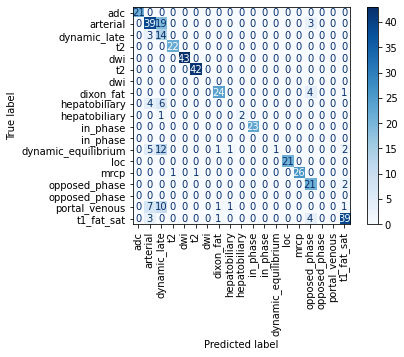

<Figure size 1800x1800 with 0 Axes>

In [10]:
f = display_and_save_results(meta_test_results_df.preds, meta_test_results_df.true, fn='meta', saveflag=False)


Preprocessing metadata for Random Forest classifier.
Have received 432 entries.
accuracy is 0.7708333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.62      0.64      0.63        61
           6       0.23      0.82      0.35        17
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       0.00      0.00      0.00        22
          17       1.00      1.00      1.00        21
          18       1.00      0.93      0.96        28
          19       0.70      0.70      0.70        23
          23       0.50      0.05      0.09        20
          25       0.74 

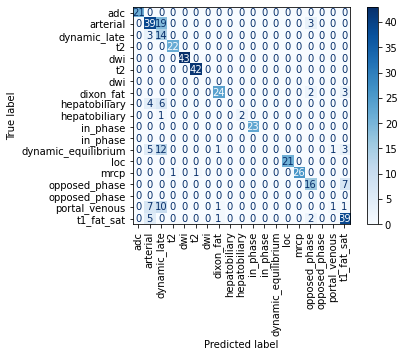

<Figure size 1800x1800 with 0 Axes>

In [31]:
## just checking to make sure the saved model is better than vanilla RF
from sklearn.ensemble import RandomForestClassifier
vanilla_model = RandomForestClassifier(min_samples_leaf=2)
vanilla_model.fit(X_train_meta[feats_to_keep], y_train)
vanillapreds, vanillaprobs, vanillay, vanillaacc = meta_inference(test_df, vanilla_model, feats_to_keep)
print('accuracy is', vanillaacc)
vanilla_results_df = make_results_df(vanillapreds, vanillaprobs, TEy, test_df)
f= display_and_save_results(vanilla_results_df.preds, vanilla_results_df.true, saveflag=False)
print(vanilla_model.get_params())

It shows no significant change in the overall accuracy compared with the default parameters...

### Getting pixel inference results

In [32]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pix = CustomResNet50(19)

# Load the saved state dictionary
saved_state_dict = torch.load('../models/pixel_model_041623.pth', map_location=device)

# Modify the keys to add the 'resnet50.' prefix
modified_state_dict = {f'resnet50.{k}': v for k, v in saved_state_dict.items()}

# Load the modified state dictionary into the current model
model_pix.load_state_dict(modified_state_dict)
model_pix = model_pix.to(device)


In [33]:

#pixel_train_preds, pixel_train_probs = pixel_inference(model_pix, train_df.fname.tolist())
#pixel_val_preds, pixel_val_probs = pixel_inference(model_pix, val_df.fname.to_list())
pixel_test_preds, pixel_test_probs = pixel_inference(model_pix, test_df.fname.to_list())

In [34]:
#pixel_train_results_df = make_results_df(pixel_train_preds, pixel_train_probs, Ty, train_df)
#pixel_val_results_df = make_results_df(pixel_val_preds, pixel_val_probs, Vy, val_df)
pixel_test_results_df = make_results_df(pixel_test_preds, pixel_test_probs, TEy, test_df)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.83      0.85      0.84        61
           6       0.89      1.00      0.94        17
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        43
           9       1.00      0.98      0.99        42
          11       1.00      1.00      1.00        29
          12       0.00      0.00      0.00        10
          13       1.00      0.33      0.50         3
          14       1.00      0.83      0.90        23
          16       0.57      0.36      0.44        22
          17       1.00      0.95      0.98        21
          18       1.00      1.00      1.00        28
          19       0.81      0.96      0.88        23
          23       0.42      0.75      0.54        20
          25       0.90      0.91      0.91        47

    accuracy                           0.88       432
   macro avg       0.84   

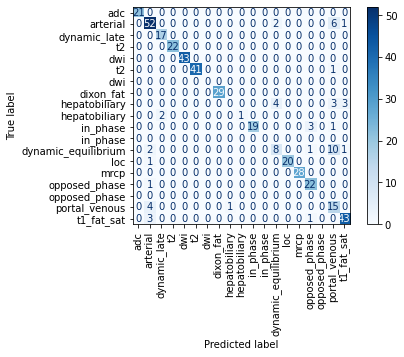

<Figure size 1800x1800 with 0 Axes>

In [35]:
f = display_and_save_results(pixel_test_results_df.preds, pixel_test_results_df.true, fn='pixel', saveflag=False)

### Getting NLP inference


In [36]:
# Load the pickled model
with open('../models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

In [37]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
senttrans_model = SentenceTransformer(sentence_encoder, device=device)



In [38]:
from NLP.NLP_training import train_NLP_model
train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, text_model_T = train_NLP_model(train_df, val_df, test_df, senttrans_model=senttrans_model)
print(train_acc, val_acc, test_acc)

Accuracy on the training set is 0.953
size of preds_val is  354
Accuracy on the val set is 0.960
Accuracy on the test set is 0.963
0.9525200876552228 0.96045197740113 0.9629629629629629


In [39]:
get_NLP_inference(NLP_model, filenames = [train_df.fname[0]])

/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (35-68)/0052.dcm


(array([8]),
 array([2.05830697e-02, 1.09033896e-02, 9.21967902e-04, 1.18682510e-03,
        8.91965271e-01, 2.32301806e-02, 3.88249769e-04, 1.11549243e-02,
        2.69171811e-03, 8.54710155e-04, 5.62693953e-03, 3.48056692e-04,
        4.63554106e-03, 2.39543446e-03, 2.17179292e-03, 7.22289270e-03,
        3.47885500e-04, 3.88035863e-03, 9.49079232e-03]))

In [40]:

nlp_test_preds, nlp_test_probs = get_NLP_inference(NLP_model, test_df.fname.tolist())
#nlp_train_preds, nlp_train_probs = get_NLP_inference(NLP_model, train_df.fname.tolist())
#nlp_val_preds, nlp_val_probs = get_NLP_inference(NLP_model, val_df.fname.tolist())


/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_spli

In [41]:
print(classification_report(nlp_test_preds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.98      0.95      0.97        63
           6       1.00      0.85      0.92        20
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       0.86      1.00      0.93        25
          12       0.60      1.00      0.75         6
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00        23
          16       1.00      0.81      0.90        27
          17       1.00      1.00      1.00        21
          18       0.96      1.00      0.98        27
          19       1.00      1.00      1.00        23
          23       1.00      0.91      0.95        22
          25       0.94      0.96      0.95        46

    accuracy                           0.96       432
   macro avg       0.90   

In [23]:
nlp_train_results_df = make_results_df(nlp_train_preds, nlp_train_probs, Ty, train_df)
nlp_val_results_df = make_results_df(nlp_val_preds, nlp_val_probs, Vy, val_df)
nlp_test_results_df = make_results_df(nlp_test_preds, nlp_test_probs, TEy, test_df)

#change names of preds, probs 
for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)


In [24]:
#change names of preds, probs 
for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)

for frame_df in [pixel_train_results_df, pixel_val_results_df, pixel_test_results_df]:
    frame_df.rename(columns={'preds':'pixel_preds', 'probs':'pixel_probs'}, inplace=True)

for frame_df in [meta_train_results_df, meta_val_results_df, meta_test_results_df]:
    frame_df.rename(columns={'preds':'meta_preds', 'probs':'meta_probs'}, inplace=True)


## Create fusion model

In [25]:
# fusion_train_df = pixel_train_results_df.copy()
# fusion_train_df[['meta_preds', 'meta_probs']] = meta_train_results_df[['meta_preds', 'meta_probs']]
# fusion_train_df[['nlp_preds', 'nlp_probs']] = nlp_train_results_df[['nlp_preds', 'nlp_probs']]


In [26]:
# fusion_val_df = pixel_val_results_df.copy()
# fusion_val_df[['meta_preds', 'meta_probs']] = meta_val_results_df[['meta_preds', 'meta_probs']]
# fusion_val_df[['nlp_preds', 'nlp_probs']] = nlp_val_results_df[['nlp_preds', 'nlp_probs']]


In [27]:
# fusion_test_df = pixel_test_results_df.copy()
# fusion_test_df[['meta_preds', 'meta_probs']] = meta_test_results_df[['meta_preds', 'meta_probs']]
# fusion_test_df[['nlp_preds', 'nlp_probs']] = nlp_test_results_df[['nlp_preds', 'nlp_probs']]


In [19]:
# loading the data back from pickled dataframes
with open('../data/fusion_train.pkl', 'rb') as file:
    ftrain = pickle.load(file)

with open('../data/fusion_val.pkl', 'rb') as file:
    fval = pickle.load(file)

with open('../data/fusion_test.pkl', 'rb') as file:
    ftest = pickle.load(file)



In [24]:
ftrain[['meta_probs', 'pixel_probs', 'nlp_probs', 'true']].values.shape

(1369, 4)

In [15]:
fusion_model = FusionModel


num_classes = 19  # Number of classes
pixel_model = model
fusion_model = FusionModel(meta_model, pixel_model, NLP_model, num_classes)
meta_and_pixel_fusion_model = PartialFusionModel(meta_model, pixel_model, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.001)
p_optimizer = torch.optim.Adam(meta_and_pixel_fusion_model.parameters(), lr=0.001)

NameError: name 'model' is not defined

In [ ]:
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(y_train_fusion), batch_size):
        actual_batch_size = min(batch_size, len(Xtrain1) - i)
        X1_batch = torch.tensor(np.array(Xtrain1[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        X2_batch = torch.tensor(np.array(Xtrain2[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        X3_batch = torch.tensor(np.array(Xtrain3[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        y_batch = torch.tensor(y_train_fusion[i:i+actual_batch_size], dtype=torch.long)

        # print(f"X1_batch shape: {X1_batch.shape}")
        # print(f"X2_batch shape: {X2_batch.shape}")
        # print(f"X3_batch shape: {X3_batch.shape}")
        # print(f"y_batch shape: {y_batch.shape}")


        optimizer.zero_grad()
        outputs = fusion_model(X1_batch, X2_batch, X3_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/20], Loss: 2.7594962120056152
Epoch [2/20], Loss: 2.549872636795044
Epoch [3/20], Loss: 2.347651481628418
Epoch [4/20], Loss: 2.153589963912964
Epoch [5/20], Loss: 1.9685009717941284
Epoch [6/20], Loss: 1.793197512626648
Epoch [7/20], Loss: 1.6284205913543701
Epoch [8/20], Loss: 1.4747648239135742
Epoch [9/20], Loss: 1.3326175212860107
Epoch [10/20], Loss: 1.202121615409851
Epoch [11/20], Loss: 1.0831702947616577
Epoch [12/20], Loss: 0.9754281640052795
Epoch [13/20], Loss: 0.8783715963363647
Epoch [14/20], Loss: 0.7913391590118408
Epoch [15/20], Loss: 0.7135814428329468
Epoch [16/20], Loss: 0.6443043351173401
Epoch [17/20], Loss: 0.5827059149742126
Epoch [18/20], Loss: 0.5280027985572815
Epoch [19/20], Loss: 0.4794508218765259
Epoch [20/20], Loss: 0.4363558888435364


In [ ]:
Xtest1 = fusion_test_df.meta_probs.values
Xtest2 = fusion_test_df.pixel_probs.values
Xtest3 = fusion_test_df.nlp_probs.values

Xtest1 = np.stack(Xtest1, axis=0)
Xtest2 = np.stack(Xtest2, axis=0)
Xtest3 = np.stack(Xtest3, axis=0)

out_features = 19

actual_classes = [0,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,23,25]
y_test_fusion = np.array([actual_classes.index(x) for x in fusion_test_df.true])

In [ ]:
print(Xtest1.shape, Xtest2.shape, Xtest3.shape, y_test_fusion.shape)

(432, 19) (432, 19) (432, 19) (432,)


In [ ]:
import torch.nn.functional as F
# Evaluate the model with the test data
with torch.no_grad():
    X1_test_t = torch.tensor(Xtest1, dtype=torch.float32)
    X2_test_t = torch.tensor(Xtest2, dtype=torch.float32)
    X3_test_t = torch.tensor(Xtest3, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_fusion, dtype=torch.long)

    outputs = fusion_model(X1_test_t, X2_test_t, X3_test_t)
    f_probabilities = F.softmax(outputs, dim=1)  # Apply softmax to the outputs

    _, f_predicted = torch.max(outputs, 1)
    correct = (f_predicted == y_test_t).sum().item()
    f_accuracy = correct / len(y_test_t) * 100

print(f'Test accuracy: {f_accuracy}%')

Test accuracy: 94.21296296296296%


In [ ]:
fusion_test_results_df = make_results_df(f_predicted, f_probabilities, y_test_t, test_df)

In [442]:
fusion_test_results_df

,preds,true,probs,patientID,series_description,contrast,plane
0,4,4,"[0.021396970376372337, 0.020487060770392418, 0.01766064763069153, 0.016244331374764442, 0.7125632166862488, 0.02500881254673004, 0.008918930776417255, 0.01569932885468006, 0.011324414052069187, 0.010730977170169353, 0.018159355968236923, 0.009191839955747128, 0.01639493927359581, 0.017215007916092873, 0.015577628277242184, 0.01548106037080288, 0.008368594571948051, 0.014795802533626556, 0.0247811246663332]",102,ax diff_TRACEW,1,ax
1,4,4,"[0.021397162228822708, 0.020487036556005478, 0.01766066811978817, 0.016244489699602127, 0.7125626802444458, 0.025007683783769608, 0.008918950334191322, 0.015699153766036034, 0.011324497871100903, 0.010731030255556107, 0.018159449100494385, 0.009191898629069328, 0.01639495976269245, 0.017214927822351456, 0.015577542595565319, 0.015481228940188885, 0.00836863648146391, 0.014795891009271145, 0.024782059714198112]",102,ax diff_TRACEW,1,ax
2,12,12,"[0.03269666060805321, 0.08453246206045151, 0.060602132230997086, 0.030212001875042915, 0.04324795678257942, 0.030636470764875412, 0.01764671504497528, 0.035457029938697815, 0.0795121043920517, 0.025039667263627052, 0.03837970271706581, 0.021747229620814323, 0.21100939810276031, 0.02996177226305008, 0.03609180077910423, 0.03974157199263573, 0.01975918561220169, 0.11220285296440125, 0.05152327939867973]",102,ax equilibrium new,1,ax
3,1,1,"[0.02039298415184021, 0.5785853266716003, 0.03681271895766258, 0.019540918990969658, 0.02806386910378933, 0.01975311152637005, 0.011304709129035473, 0.02205103076994419, 0.01842307671904564, 0.016115963459014893, 0.023295851424336433, 0.012619994580745697, 0.04500898718833923, 0.016525454819202423, 0.018567394465208054, 0.019664593040943146, 0.009975509718060493, 0.03656923398375511, 0.04672933742403984]",102,ax dyn new,1,ax
4,18,18,"[0.017389634624123573, 0.029795730486512184, 0.015073947608470917, 0.014224188402295113, 0.016708897426724434, 0.02010926604270935, 0.007709000259637833, 0.03563356399536133, 0.013885191641747952, 0.011900950223207474, 0.026158053427934647, 0.010085373185575008, 0.026317624375224113, 0.012767169624567032, 0.016225390136241913, 0.025503454729914665, 0.010427834466099739, 0.0187054593116045, 0.6713792085647583]",102,ax dixon_W,0,ax
...,...,...,...,...,...,...,...
427,4,4,"[0.022166727110743523, 0.020634325221180916, 0.017857089638710022, 0.016359593719244003, 0.7091633081436157, 0.02528732270002365, 0.008946101181209087, 0.01592734083533287, 0.01145593449473381, 0.01082950085401535, 0.018338656052947044, 0.009312472306191921, 0.016540363430976868, 0.01737906225025654, 0.015780674293637276, 0.015640340745449066, 0.00847703218460083, 0.014933442696928978, 0.024970654398202896]",58,ax diff_TRACEW,1,ax
428,3,3,"[0.017113015055656433, 0.02521120384335518, 0.019466958940029144, 0.6469280123710632, 0.029334161430597305, 0.03610522300004959, 0.011684862896800041, 0.018022747710347176, 0.01232165191322565, 0.014737758785486221, 0.019595030695199966, 0.014695871621370316, 0.017463382333517075, 0.02003064751625061, 0.026205332949757576, 0.01591380499303341, 0.014797412790358067, 0.017077220603823662, 0.02329569309949875]",58,cor haste,0,cor
429,1,1,"[0.01968565583229065, 0.5951127409934998, 0.035550929605960846, 0.018941828981041908, 0.026989372447133064, 0.01902218908071518, 0.010984986089169979, 0.02135545201599598, 0.017756065353751183, 0.015551040880382061, 0.022536177188158035, 0.012176945805549622, 0.04340915009379387, 0.01599057763814926, 0.017903372645378113, 0.018967652693390846, 0.009568898007273674, 0.03434310853481293, 0.044153790920972824]",58,ax dyn new,1,ax
430,10,10,"[0.021211950108408928, 0.029626861214637756, 0.021532874554395676, 0.018517808988690376, 0.028557738289237022, 0.026943741366267204, 0.010752583853900433, 0.04960396885871887, 0.018314946442842484, 0.01564510352909565, 0.4975303113460541, 0.014475567266345024, 0.025694185867905617, 0.01867469772696495, 0.027210615575313568, 0.08171723783016205, 0.013944628648

In [450]:
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(y_train_fusion), batch_size):
        actual_batch_size = min(batch_size, len(Xtrain1) - i)
        X1_batch = torch.tensor(np.array(Xtrain1[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        X2_batch = torch.tensor(np.array(Xtrain2[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        #X3_batch = torch.tensor(np.array(Xtrain3[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        y_batch = torch.tensor(y_train_fusion[i:i+actual_batch_size], dtype=torch.long)

        # print(f"X1_batch shape: {X1_batch.shape}")
        # print(f"X2_batch shape: {X2_batch.shape}")
        # print(f"X3_batch shape: {X3_batch.shape}")
        # print(f"y_batch shape: {y_batch.shape}")


        p_optimizer.zero_grad()
        outputs = meta_and_pixel_fusion_model(X1_batch, X2_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        p_optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/20], Loss: 2.8027234077453613
Epoch [2/20], Loss: 2.6482958793640137
Epoch [3/20], Loss: 2.4979474544525146
Epoch [4/20], Loss: 2.3518826961517334
Epoch [5/20], Loss: 2.210340976715088
Epoch [6/20], Loss: 2.0735793113708496
Epoch [7/20], Loss: 1.9418646097183228
Epoch [8/20], Loss: 1.8154579401016235
Epoch [9/20], Loss: 1.6946020126342773
Epoch [10/20], Loss: 1.579504370689392
Epoch [11/20], Loss: 1.4703285694122314
Epoch [12/20], Loss: 1.3671813011169434
Epoch [13/20], Loss: 1.2701077461242676
Epoch [14/20], Loss: 1.1790897846221924
Epoch [15/20], Loss: 1.0940468311309814
Epoch [16/20], Loss: 1.014840841293335
Epoch [17/20], Loss: 0.9412838220596313
Epoch [18/20], Loss: 0.8731458187103271
Epoch [19/20], Loss: 0.8101656436920166
Epoch [20/20], Loss: 0.7520594596862793


In [451]:
import torch.nn.functional as F
# Evaluate the model with the test data
with torch.no_grad():
    X1_test_t = torch.tensor(Xtest1, dtype=torch.float32)
    X2_test_t = torch.tensor(Xtest2, dtype=torch.float32)
    #X3_test_t = torch.tensor(Xtest3, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_fusion, dtype=torch.long)

    outputs = meta_and_pixel_fusion_model(X1_test_t, X2_test_t)
    g_probabilities = F.softmax(outputs, dim=1)  # Apply softmax to the outputs

    _, g_predicted = torch.max(outputs, 1)
    correct = (g_predicted == y_test_t).sum().item()
    g_accuracy = correct / len(y_test_t) * 100

print(f'Test accuracy: {g_accuracy}%')

Test accuracy: 89.58333333333334%


In [455]:
# for classification report and CM:
# Move the tensor to the CPU if it's on the GPU
if g_predicted.is_cuda:
    g_predicted = g_predicted.cpu()
g_predicted_list = g_predicted.tolist()
g_predictions = [classes[g] for g in g_predicted_list]


In [486]:
label_list = [abd_label_dict[str(x)]['short'] for x in actual_classes]
label_list

['adc',
 'arterial',
 'dynamic_late',
 't2',
 'dwi',
 't2',
 'dwi',
 'dixon_fat',
 'hepatobiliary',
 'hepatobiliary',
 'in_phase',
 'in_phase',
 'dynamic_equilibrium',
 'loc',
 'mrcp',
 'opposed_phase',
 'opposed_phase',
 'portal_venous',
 't1_fat_sat']

In [489]:
print(classification_report(g_predictions, TEy, labels = actual_classes, target_names = label_list))

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.93      0.78      0.85        73
       dynamic_late       1.00      0.85      0.92        20
                 t2       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
                 t2       1.00      1.00      1.00        42
                dwi       0.00      0.00      0.00         0
          dixon_fat       0.97      1.00      0.98        28
      hepatobiliary       0.00      0.00      0.00         0
      hepatobiliary       0.00      0.00      0.00         0
           in_phase       0.91      0.95      0.93        22
           in_phase       0.00      0.00      0.00         0
dynamic_equilibrium       0.41      0.60      0.49        15
                loc       0.95      1.00      0.98        20
               mrcp       1.00      1.00      1.00        28
      opposed_phase    

In [476]:
actual_classes

[0, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 25]

In [ ]:
# def duplicated_cm_plot(ytrue, ypreds, classes, fname):
    
#     cm = confusion_matrix(ytrue, ypreds, labels=classes)
#     plt.figure(figsize=(25, 25))
#     plt.tight_layout()
#     ConfusionMatrixDisplay(cm, display_labels=[abd_label_dict[str(x)]['short'] for x in classes]).plot(xticks_rotation = 'vertical', cmap='Blues')
#     plt.savefig(fname + datetime.now().strftime('%Y%m%d') + ".png", dpi=300, bbox_inches='tight')

#     plt.show()

#     return plt


<Figure size 1800x1800 with 0 Axes>

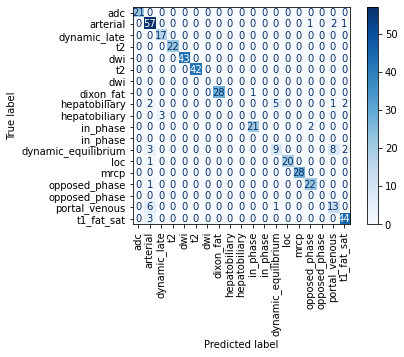

In [481]:
g_cm = duplicated_cm_plot(TEy,g_predictions, actual_classes, '../assets/figures/FigFusionMetaPixel')

In [491]:
# for classification report and CM:
# Move the tensor to the CPU if it's on the GPU
if f_predicted.is_cuda:
    f_predicted = f_predicted.cpu()
f_predicted_list = f_predicted.tolist()
f_predictions = [classes[f] for f in f_predicted_list]


<Figure size 1800x1800 with 0 Axes>

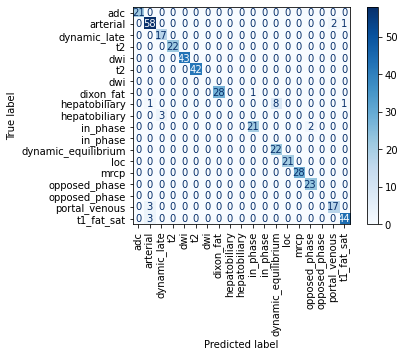

In [492]:
f_cm = duplicated_cm_plot(TEy,f_predictions, actual_classes, '../assets/figures/FigFusionAll')

In [493]:
# Save the trained fusion models to a file
with open('fusion_model041623.pkl', 'wb') as f:
    pickle.dump(fusion_model, f)

In [494]:
# Save the trained fusion models to a file
with open('meta_and_pixel_fusion_model041623.pkl', 'wb') as f:
    pickle.dump(meta_and_pixel_fusion_model, f)

# Inference fusion model

In [27]:
# ### load models
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# with open('../models/text_model20230415.st', 'rb') as file:
#     NLP_model = pickle.load(file)

# with open('../models/meta_04152023.skl', 'rb') as file:
#     meta_model = pickle.load(file)


# with open('../models/fusion_model041623.pkl', 'rb') as file:
#     fusion_model = pickle.load(file)

# with open('../models/meta_and_pixel_fusion_model041623.pkl', 'rb') as file:
#     fusion_model_part = pickle.load(file)

# def load_pixel_model(modelpath, device=device, output_units = 19):
    
#     model = models.resnet50(pretrained=True) # Load the ResNet50 model 

#     # Replace the output layer to match the number of output units in your fine-tuned model
#     num_finetuned_output_units = output_units
#     num_features = model.fc.in_features
#     model.fc = torch.nn.Linear(num_features, num_finetuned_output_units)

#     # Load the saved state_dict
#     state_dict = torch.load(modelpath, map_location=device)
#     model.load_state_dict(state_dict)

#     return model

# pixel_model = load_pixel_model('../models/pixel_model_041623.pth')



In [12]:



# def get_fusion_model_prediction(row, model1 = meta_model, model2=pixel_model, model3=NLP_model, fusion_model = fusion_model, device=device,features=feats_to_keep, num_classes=len(classes)):
#     #meta_data, pixel_data, text_data = extract_data_for_models(row)
    
#     prob1 = get_meta_probs(row, model1, features) 
#     prob1_tensor = torch.tensor(prob1, dtype=torch.float32).squeeze()
#     #print(f'shape of prob1_tensor is {prob1_tensor.shape}')
    
#     _, prob2 = get_pixel_preds_and_probs(model2, [row.fname], classes=classes)
#     prob2_tensor = torch.tensor(prob2, dtype=torch.float32)
#     #print(f'shape of prob2_tensor is {prob2_tensor.shape}')
    
    
#     _, prob3 = get_NLP_inference(model3, [row.fname], device, classes=classes)
#     prob3_tensor = torch.tensor(prob3, dtype=torch.float32)
#     #print(f'shape of prob3_tensor is {prob3_tensor.shape}')
    

#    # print(prob1_tensor, prob2_tensor, prob3_tensor)
#     #print(torch.cat((prob1_tensor, prob2_tensor, prob3_tensor), dim=0))

#     # Pass the tensors through the FusionModel
#     fused_output=  fusion_model(prob1_tensor, prob2_tensor, prob3_tensor)
    
#     # Get the predicted class and confidence score
#     predicted_class = classes[torch.argmax(fused_output, dim=0).item()]
#     confidence_score = torch.max(torch.softmax(fused_output, dim=0)).item()
    
#     return predicted_class, confidence_score

In [13]:

# from model_container import ModelContainer
# from fusion_model.fus_model import FusionModel
# from process_tree import Processor

# old_data_site = '/volumes/cm7/Abdominal_MRI_dataset_split/test/'
# destionate_site = 'volumes/cm7/wacky'

model_container = ModelContainer()

fusion_model = FusionModel(cnn_model, metadata_model, nlp_model, fusion_weights, num_classes=len(classes), features=feats_to_keep, classes=classes, include_nlp=True)
   
# processor = Processor(old_data_site, destination_site, fusion_model=fusion_model, write_labels=True)
# new_processed_df = processor.pipeline_new_studies()

fus_preds = []
for i in range(20):
    fus_pred = get_fusion_inference(row=X_test_meta.iloc[i])
    fus_preds.append(fus_pred)
print(fus_preds)
#print(test_df.label.tolist()[:20])

### i need to have a preprocessed dataframe, or a method to 'preprocess' a single row for the meta but still have the other info...or pass it 
### a dataframe on a single row

TypeError: __init__() missing 4 required positional arguments: 'cnn_model', 'metadata_model', 'nlp_model', and 'fusion_weights'

In [17]:
test_df.fname[0]

'/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm'

# Playing with writing results into DICOM metadata

In [ ]:

# moved to fus_inference
# def write_labels_into_dicom(series_group, label_num, conf_num, path):
#     #print('writing labels', label_num)
#     for dicom_file in series_group.fname.tolist():
#         filename = os.path.basename(dicom_file)
#         ds = dcmread(dicom_file, no_pixels=False)

#         private_creator_tag = pydicom.tag.Tag(0x0011, 0x0010)
#         custom_tag1 = pydicom.tag.Tag(0x0011, 0x1010)
#         custom_tag2 = pydicom.tag.Tag(0x0011, 0x1011)

#         # Check if private creator and custom tags already exist
#         if private_creator_tag not in ds or custom_tag1 not in ds or custom_tag2 not in ds:
#             # Create and add private creator element
#             private_creator = pydicom.DataElement(private_creator_tag, 'LO', 'PredictedClassInfo')
#             ds[private_creator_tag] = private_creator

#             # Create and add custom private tags
#             data_element1 = pydicom.DataElement(custom_tag1, 'IS', str(label_num))
#             data_element1.private_creator = 'PredictedClassInfo'
#             data_element2 = pydicom.DataElement(custom_tag2, 'DS', str(conf_num))
#             data_element2.private_creator = 'PredictedClassInfo'
#             ds[custom_tag1] = data_element1
#             ds[custom_tag2] = data_element2

#             modified_file_path = os.path.join(path, filename)
#             ds.save_as(modified_file_path)
#         else:
#             print(f"Custom tags already exist in {dicom_file}, skipping this file.")

#         modified_file_path = os.path.join(path, filename)
#         ds.save_as(modified_file_path)  






# playing with read world data

In [46]:
sys.path.append('../scripts')
from fusion_model.fus_model import FusionModel
from model_container import ModelContainer



ImportError: cannot import name 'model_paths' from 'config' (/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/config.py)

In [43]:
from fusion_model.fus_model import FusionModel
from process_tree import Processor
from model_container import ModelContainer

data_dir = '/volumes/cm7/processed/'
destination_folder = '/volumes/cm7/testing_the_model'

models = ModelContainer()
fusion_model = FusionModel(models, num_classes=19, include_nlp=True)
processor = Processor(data_dir=data_dir, destination_folder=destination_folder, fusion_model=fusion_model)


ImportError: cannot import name 'Processor' from 'process_tree' (/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/process_tree.py)

In [ ]:
def process_batch(df, data_dir, destination_folder, write_labels=True):

    df1 = df.copy()
    #print('In batch, columns are: ', df1.columns)
    batch = df1.groupby('patientID').apply(lambda x: process_patient(x, data_dir, destination_folder, write_labels))
    
    # print('writing labels into dicom in location ', dest_name)
    # for filename in batch.fname:

    return batch

def process_patient(patient_df, data_dir, destination_folder, write_labels):
    processed_exams = patient_df.groupby('exam').apply(lambda x: process_exam(x, data_dir, destination_folder, write_labels))
    return processed_exams


def process_exam(exam_df, data_dir, destination_folder, write_labels):
    # Group exam data by series and apply the process_series function
    processed_series = exam_df.groupby('series').apply(lambda x: process_series(x, data_dir, destination_folder))

    #result = pd.concat(processed_series)
    result = processed_series
    return result
    
def process_series(series_df, data_dir, destination_folder, write_labels, selection_fraction=0.5):
    # Sort the dataframe by file_info (or another relevant column)
    sorted_series = series_df.sort_values(by='fname')

    # Find the middle image index
    middle_index = int(len(sorted_series) * selection_fraction)

    # Get the middle image
    middle_image = sorted_series.iloc[middle_index]

    predicted_series_class, predicted_series_confidence = get_fusion_model_prediction(middle_image)

    sorted_series['predicted_class'] = predicted_series_class
    sorted_series['prediction_confidence'] = np.round(predicted_series_confidence, 2)

    #save_path = f'/volumes/cm7/processed/modified/{series_df.patientID}/{series_df.exam}/{series_df["series"]}/'

     # Define the save path relative to data_dir
    relative_path = os.path.relpath(series_df.fname.iloc[0], data_dir)
    save_path = os.path.join(data_dir, destination_folder, os.path.dirname(relative_path))

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    if write_labels:
        #print('writing new data into', save_path)
        write_labels_into_dicom(sorted_series, label_num=predicted_series_class,
                            conf_num=np.round(predicted_series_confidence, 3), path=save_path)

    return sorted_series
    



In [91]:
def pipeline_new_image_df(data_dir, dest_name='modified', write_labels = True):
    # create the df of image data    
    _, df = get_dicoms(data_dir)
    df1 = df.copy()
    ## manipulate df prior to evaluation
    df1 = expand_filename(df1, ['blank', 'filename', 'series', 'exam', 'patientID'])
    df1.drop(columns='blank', inplace=True)
    df1['file_info']=df1.fname
    df1['img_num'] = df1.file_info.apply(extract_image_number)
    df1['contrast'] = df1.apply(detect_contrast, axis=1)
    df1['plane'] = df1.apply(compute_plane, axis=1)
    df1['series_num'] = df1.series.apply(lambda x: str(x).split('_')[-1])
    #print('columns before preprocess are', df1.columns)

    df1 = preprocess(df1)
   # print('after preprocessin exam is in columns?', ('exam' in df1.columns))
    #print('after preprocessing series is in columns?', ('series' in df1.columns))
    #process the batch of studies
    processed_frame = process_batch(df1, data_dir, dest_name, write_labels)

    return processed_frame


In [40]:

importlib.reload(process_tree)

<module 'process_tree' from '/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/process_tree.py'>

In [41]:


data_dir = '/volumes/cm7/processed/'
modified_df = pipeline_new_image_df(data_dir, write_labels=False)
modified_df

Finding DICOM files. This may take a few minutes.
Reading DICOM files with extensions .dcm, .dicom, .dcim, or .ima. This may take a few minutes, depending on the number of files to read...
Preprocessing metadata for Random Forest classifier.
Have received 8270 entries.


TypeError: get_fusion_inference() missing 5 required positional arguments: 'model1', 'model2', 'model3', 'fusion_model', and 'device'

In [71]:
modified_df

fname  \
patientID       exam                                               series                                                                                                                                                                                  
CmmDemoCase6    Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd (135298011)(135298001)_10801   7042              /volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0001.dcm   
                                                                                                  7036              /volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0002.dcm   
                                                                                                  7039              /volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0003.dcm   
                                                                                                  7046              /volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0004.dcm   
                                                                                                  7049              /volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0005.dcm   
...                                                                                                                                                                                                                                                  ...   
Cmm_Demo_Case_2 Mri_Abdomen_With_And_Without_Contrast - 22575580   eADCApr_05_2023_204823_EDT_651 4559  /volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0128.dcm   
                                                                                                  4564  /volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0129.dcm   
                                                                                                  4596  /volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0130.dcm   
                                                                                                  4601  /volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0131.dcm   
                                                                                                  4592  /volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0132.dcm   

                                                                                                                                                                                                                                               file_info  \
patientID       exam                                               series                                                                                                                                                                                  
CmmDemoCase6    Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd (135298011)(135298001)_10801   7042              /volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0001.dcm   
                                                                                                  7036              /volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298

In [70]:
## the prediction confidence seems low:  lets take a look:
confidences = sorted(modified_df.prediction_confidence, reverse=True)
confidences

[0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.69,
 0.69,
 0.57,
 0.57,
 0.57,
 0.57,
 0.57,
 0.57,
 0.56,
 0.56,
 0.56,
 0.56,
 0.56,
 0.56,
 0.55,
 0.55,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.51,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48

In [73]:
modified_df_2 = modified_df.reset_index(drop=True)
modified_df_2

,fname,file_info,patientID,PatientID,StudyInstanceUID,StudyID,exam,SeriesInstanceUID,SeriesNumber,SeriesDescription,...,opt_RAMP_IS_GEMS,opt_S,opt_SAT1,opt_T,opt_T2FLAIR_GEMS,opt_VASCTOF_GEMS,opt_VB_GEMS,opt__,predicted_class,prediction_confidence
0,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0001.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0001.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709433400129.29161,10801,(13529/801/1)-(13529/800/1),...,0,0,0,0,0,0,0,0,0,0.13
1,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0002.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0002.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709433400129.29161,10801,(13529/801/2)-(13529/800/2),...,0,0,0,0,0,0,0,0,0,0.13
2,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0003.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0003.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709433400129.29161,10801,(13529/801/3)-(13529/800/3),...,0,0,0,0,0,0,0,0,0,0.13
3,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0004.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0004.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709433400129.29161,10801,(13529/801/4)-(13529/800/4),...,0,0,0,0,0,0,0,0,0,0.13
4,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0005.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0005.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709433400129.29161,10801,(13529/801/5)-(13529/800/5),...,0,0,0,0,0,0,0,0,0,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8265,/volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0128.dcm,/volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0128.dcm,Cmm_Demo_Case_2,dd90a5c9,1.2.276.0.45.1.7.2.161961477039.23041308561400128.40986,22575580,Mri_Abdomen_With_And_Without_Contrast - 22575580,1.2.276.0.45.1.7.3.161961477039.23041308563300377.40986,651,eADC:Apr 05 2023 20-48-23 EDT,...,0,0,0,0,0,0,0,0,0,0.22
8266,/volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0129.dcm,/volumes/cm7/processed/modified/Cmm_Demo_Case_2/Mri_Abdomen_With_And_Without_Contrast - 22575580/eADCApr_05_2023_204823_EDT_651/IM-0012-0129.dcm,Cmm_Demo_Case_2,dd90a5c9,1.2.276.0.45.1.7.2.161961477039.23041308561400128.40986,22575580,Mri_Abdomen_With_And_Without_Contrast - 22575580,1.2.276.0.45.1.7.3.161961477039.23041308563300377.40986,651,eADC

In [77]:
modified_df_2.SeriesDescription.nunique()

292

In [79]:
troubleshootingdf = modified_df_2[['SeriesDescription', 'predicted_class', 'prediction_confidence']]
troubleshootingdf.sort_values('prediction_confidence', ascending=False)

,SeriesDescription,predicted_class,prediction_confidence
5548,cor thick slab mrcp,18,0.70
5546,cor thick slab mrcp,18,0.70
5551,cor thick slab mrcp,18,0.70
5550,cor thick slab mrcp,18,0.70
5549,cor thick slab mrcp,18,0.70
...,...,...,...
636,FAT: cor lava +c,14,0.11
637,FAT: cor lava +c,14,0.11
638,FAT: cor lava +c,14,0.11
639,FAT: cor lava +c,14,0.11


In [90]:
# Group by the 'label' column and count the occurrences of each predicted class
grouped_counts = troubleshootingdf.groupby('SeriesDescription')['predicted_class'].value_counts()

# Display the counts as a DataFrame
tscount_df = grouped_counts.reset_index(name='count')
print(tscount_df[-50:])

                 SeriesDescription  predicted_class  count
244                COL:cor 3D mrcp               18      2
245                FAT: Ph1/ax dyn               16    120
246                FAT: Ph2/ax dyn               16    120
247                    FAT: ax dyn               16    120
248            FAT: ax equilibrium               16    120
249              FAT: ax lava flex               11    120
250          FAT: ax portal venous               16    120
251               FAT: cor lava +c               14    184
252             FAT: cor lava flex               17    124
253          InPhase: ax lava flex               14    320
254         OutPhase: ax lava flex               16    320
255            Ph1/ax lava dynamic                2    240
256             Ph1/ax lava portal               18    240
257            Ph2/ax lava dynamic               18    240
258             Ph2/ax lava portal               18    240
259              WATER: Ph1/ax dyn                2    1

In [88]:
modified_df_2[modified_df_2.SeriesDescription=='ax lava dynamic']


,fname,file_info,patientID,PatientID,StudyInstanceUID,StudyID,exam,SeriesInstanceUID,SeriesNumber,SeriesDescription,...,opt_RAMP_IS_GEMS,opt_S,opt_SAT1,opt_T,opt_T2FLAIR_GEMS,opt_VASCTOF_GEMS,opt_VB_GEMS,opt__,predicted_class,prediction_confidence
2660,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0001.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0001.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709434600507.29161,800,ax lava dynamic,...,0,0,0,0,0,0,0,0,18,0.13
2661,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0002.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0002.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709434600507.29161,800,ax lava dynamic,...,0,0,0,0,0,0,0,0,18,0.13
2662,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0003.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0003.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709434600507.29161,800,ax lava dynamic,...,0,0,0,0,0,0,0,0,18,0.13
2663,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0004.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0004.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709434600507.29161,800,ax lava dynamic,...,0,0,0,0,0,0,0,0,18,0.13
2664,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0005.dcm,/volumes/cm7/processed/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0005.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709434600507.29161,800,ax lava dynamic,...,0,0,0,0,0,0,0,0,18,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,/volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0116.dcm,/volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0116.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709434600507.29161,800,ax lava dynamic,...,0,0,0,0,0,0,0,0,18,0.13
2896,/volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0117.dcm,/volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0117.dcm,CmmDemoCase6,78e1a31e,1.2.276.0.45.1.7.2.161961477039.23041709432600003.29161,1d96a0fd,Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd,1.2.276.0.45.1.7.3.161961477039.23041709434600507.29161,800,ax lava dynamic,...,0,0,0,0,0,0,0,0,18,0.13
2897,/volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ax_lava_dynamic_800/IM-0016-0118.dcm,/volumes/cm7/processed/mo

In [76]:
ax_diff = modified_df_2[modified_df_2.SeriesDescription=='ax diff']
ax_diff.predicted_class.value_counts(), ax_diff.shape

(8    408
 Name: predicted_class, dtype: int64,
 (408, 134))

In [89]:
abd_label_dict['18']['short']

'mrcp'

In [66]:
from pydicom.pixel_data_handlers import pylibjpeg_handler

pydicom.config.image_handlers = [pylibjpeg_handler]


q = dcmread(ns1.iloc[0].fname, no_pixels=False)
q.pixel_array

RuntimeError: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )

RuntimeError: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. ), pylibjpeg (req. )

In [93]:
def select_one_image(series, selection_fraction=0.5):
    sorted_series = series.sort_values()
    #print(sorted_series)
    index = int(len(sorted_series) * selection_fraction)
    print(index, len(sorted_series))
    return sorted_series.iloc[index]

In [24]:
def mask_one_from_series2(df, selection_fraction=0.5):
    def select_one_image(series):
        sorted_series = series.sort_values()
        index = int(len(sorted_series) * selection_fraction)
        return sorted_series.iloc[index]

    df = df.sort_values(by=['patientID', 'series', 'file_info'])

    grouped_df = df.groupby(['patientID', 'series'])
    selected_rows = grouped_df.agg(select_one_image).reset_index()
    
    return selected_rows

# Example usage
# data = {'patientID': [1, 1, 1, 2, 2, 3, 3, 3, 3],
#         'series': [1, 1, 2, 1, 2, 1, 1, 2, 2],
#         'file_info': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']}

# df = pd.DataFrame(data)
# selected_rows = mask_one_from_series(df, selection_fraction=0.5)
# print(selected_rows)

In [26]:
ns19 = mask_one_from_series2(ns18)
ns19

,patientID,series,SOPClassUID,Manufacturer,StudyDescription,SeriesDescription,ManufacturerModelName,PatientID,ContrastBolusAgent,BodyPartExamined,...,AcquisitionNumber,InstanceNumber,PhotometricInterpretation,fname,filename,exam,file_info,img_num,contrast,plane
0,Cmm_Demo_Case1,Localizers_1,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,localizer,Skyra,20b8577e,NaN,ABDOMEN,...,1.0,7,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/Localizers_1/IM-0020-0007.dcm,IM-0020-0007.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/Localizers_1/IM-0020-0007.dcm,7,0,cor
1,Cmm_Demo_Case1,Visage_Presentation_State_9788,Grayscale Softcopy Presentation State Storage,Visage PR,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,Visage Presentation State,Skyra,20b8577e,NaN,NaN,...,NaN,1,NaN,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/Visage_Presentation_State_9788/IM-0019-0001.dcm,IM-0019-0001.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/Visage_Presentation_State_9788/IM-0019-0001.dcm,1,0,unknown
2,Cmm_Demo_Case1,ax_diff_ADC_DFC_MIX_8,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax diff_ADC_DFC_MIX,Skyra,20b8577e,NaN,ABDOMEN,...,1.0,23,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_diff_ADC_DFC_MIX_8/IM-0007-0023.dcm,IM-0007-0023.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_diff_ADC_DFC_MIX_8/IM-0007-0023.dcm,23,0,ax
3,Cmm_Demo_Case1,ax_diff_DFC_MIX_7,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax diff_DFC_MIX,Skyra,20b8577e,NaN,ABDOMEN,...,1.0,46,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_diff_DFC_MIX_7/IM-0006-0046.dcm,IM-0006-0046.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_diff_DFC_MIX_7/IM-0006-0046.dcm,46,0,ax
4,Cmm_Demo_Case1,ax_dixon_dyn_W_15,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon dyn_W,Skyra,20b8577e,NaN,ABDOMEN,...,1.0,41,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_15/IM-0012-0041.dcm,IM-0012-0041.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_15/IM-0012-0041.dcm,41,1,ax
5,Cmm_Demo_Case1,ax_dixon_dyn_W_17,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon dyn_W,Skyra,20b8577e,NaN,ABDOMEN,...,2.0,41,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_17/IM-0013-0041.dcm,IM-0013-0041.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_17/IM-0013-0041.dcm,41,1,ax
6,Cmm_Demo_Case1,ax_dixon_dyn_W_19,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon dyn_W,Skyra,20b8577e,NaN,ABDOMEN,...,3.0,41,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_19/IM-0014-0041.dcm,IM-0014-0041.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_19/IM-0014-0041.dcm,41,1,ax
7,Cmm_Demo_Case1,ax_dixon_equilibrium_W_24,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon equilibrium_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,...,1.0,41,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Wi

In [15]:
ns17 = new_scan_df_1.copy()

# Create a mask where each element is True if the corresponding value is a MultiValue instance
multivalue_mask = ns17.applymap(lambda x: isinstance(x, DcmMultiValue))

# Get the indices of the rows containing MultiValue instances
cols_to_remove = multivalue_mask.any(axis=0)
cols_to_remove
# Remove the rows containing MultiValue instances
# df_cleaned = ns17.loc[~rows_to_remove]


ImageType                     True
SOPClassUID                  False
Manufacturer                 False
StudyDescription             False
SeriesDescription            False
ManufacturerModelName        False
PatientID                    False
ContrastBolusAgent           False
BodyPartExamined             False
ScanningSequence             False
SequenceVariant               True
ScanOptions                   True
MRAcquisitionType            False
SequenceName                 False
AngioFlag                    False
SliceThickness               False
RepetitionTime               False
EchoTime                     False
MagneticFieldStrength        False
EchoTrainLength              False
StudyInstanceUID             False
SeriesInstanceUID            False
StudyID                      False
SeriesNumber                 False
AcquisitionNumber            False
InstanceNumber               False
ImageOrientationPatient       True
PhotometricInterpretation    False
PixelSpacing        

In [25]:

nsd2 = new_scan_df_1.copy()


In [28]:
nsd3 = preprocess(nsd2)
nsd3

Preprocessing metadata for Random Forest classifier.
Have received 1095 entries.


,fname,patientID,PatientID,StudyInstanceUID,StudyID,SeriesInstanceUID,SeriesNumber,SeriesDescription,AcquisitionNumber,InstanceNumber,...,opt_SAT1,opt_SAT_GEMS,opt_SEQ_GEMS,opt_SP,opt_T,opt_T2FLAIR_GEMS,opt_TRF_GEMS,opt_VASCTOF_GEMS,opt_VB_GEMS,opt__
0,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,72,...,0,0,0,0,0,0,0,0,0,0
1,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0066.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,66,...,0,0,0,0,0,0,0,0,0,0
2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0067.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,67,...,0,0,0,0,0,0,0,0,0,0
3,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0073.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,73,...,0,0,0,0,0,0,0,0,0,0
4,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0065.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,65,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0050.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,4,ax vibe dixon_in,1.0,50,...,0,0,0,0,0,0,0,0,0,0
1091,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0044.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,4,ax vibe dixon_in,1.0,44,...,0,0,0,0,0,0,0,0,0,0
1092,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0045.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,4,ax vibe dixon_in,1.0,45,...,0,0,0,0,0,0,0,0,0,0
1093,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0051.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,4,ax vibe dixon_in,1.0,51,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Load the pickled model
with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)

In [62]:
dyiprobs = get_meta_probs(nsd3.iloc[100])

dyiprobs

array([[8.84718499e-04, 1.26353300e-02, 2.16006052e-02, 2.97885016e-03,
        4.45040214e-03, 1.68677391e-03, 0.00000000e+00, 7.10540475e-02,
        0.00000000e+00, 4.27738270e-03, 1.68412873e-02, 1.35910039e-03,
        3.94766369e-02, 1.59586285e-01, 1.34048257e-03, 3.16364340e-02,
        1.69422103e-03, 4.76224072e-04, 6.28021219e-01]])

In [31]:
trialN = get_probs_from_file(nsd3.fname[0])
trialN

FileNotFoundError: [Errno 2] No such file or directory: "(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'"

KeyError: 'series'

In [574]:
# 


In [577]:
nsd3 = nsd2.copy()
nsd3['plane'] = nsd3.apply(compute_plane_new, axis=1)
nsd3

,ImageType,SOPClassUID,Manufacturer,StudyDescription,SeriesDescription,ManufacturerModelName,PatientID,ContrastBolusAgent,BodyPartExamined,ScanningSequence,...,directory_folder,patientID,exam,series,filename,file,file_info,img_num,contrast,plane
0,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0072.dcm,IM-0015-0072.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm,72,1,ax
1,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0066.dcm,IM-0015-0066.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0066.dcm,66,1,ax
2,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0067.dcm,IM-0015-0067.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0067.dcm,67,1,ax
3,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0073.dcm,IM-0015-0073.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0073.dcm,73,1,ax
4,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0065.dcm,IM-0015-0065.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0065.dcm,65,1,ax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_vibe_dixon_in_4,IM-0003-0050.dcm,IM-0003-0050.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0050.dcm,50,0,ax
1092,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_vibe_dixon_in_4,IM-0003-0044.dcm,IM-0003-0044.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0044.dcm,44,0,ax
1093,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_vibe_dixon_in_4,IM-0003-0045.dcm,IM-0003-0045.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0045.dcm,45,0,ax
1094,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI M

In [572]:


# def filter_out_mv(df):
#     # Create a boolean mask to identify rows with MultiValue objects in any column
#     mask = df.applymap(lambda x: isinstance(x, MultiValue)).any(axis=1)
#     #print(df[mask])
#     # Invert the mask to select rows without MultiValue objects
#     rows_without_multivalue = ~mask

#     # Filter out rows with MultiValue objects in any column
#     filtered_df = df[rows_without_multivalue]

#     return mask, filtered_df

#from pydicom.multival import MultiValue
# def compute_plane_new(row):
#     '''
#     Computes the plane of imaging from the direction cosines provided in the `ImageOrientationPatient` field.
#     The format of the values in this field is: `[x1, y1, z1, x2, y2, z2]`,
#     which correspond to the direction cosines for the first row and column of the image pixel data.
#     '''
#     planes = ['sag', 'cor', 'ax']
#     if 'ImageOrientationPatient1' in row.keys():
#         dircos = [v for k, v in row.items() if 'ImageOrientationPatient' in k]
#     else:
#         dircos = row['ImageOrientationPatient']

#         # Handle MultiValue objects by converting them to a list of floats
#         if isinstance(dircos, MultiValue):
#             dircos = [float(x) for x in dircos]

#     # Check if dircos has the expected length
#     if not isinstance(dircos, float) and len(dircos) == 6:
#         dircos = np.array(dircos).reshape(2, 3)
#         pnorm = abs(np.cross(dircos[0], dircos[1]))
#         return planes[np.argmax(pnorm)]
#     else:
#         return 'unknown'



0       ax
1       ax
2       ax
3       ax
4       ax
        ..
1091    ax
1092    ax
1093    ax
1094    ax
1095    ax
Length: 1096, dtype: object

/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm